<h1>Morpheus Model Tutorial: Deep Learning Galaxy Classifications for Roman</h1>

<h3>
    Ryan Hausen</br>
</h3>

This notebook accessed here:https://tinyurl.com/morpheus-roman
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanhausen/roman-expo-morpheus/blob/main/Roman-Expo-Workshop.ipynb)
<small>note: if you're running in Colab, you can enable GPU/TPU acceleration, by going to: Edit->Notebook settings->Hardware accelerator</small>

## Import Required Libraries

In [ ]:
# if your running on Colab or you haven't installed morpheus 
# you need to install the package.
!pip install morpheus-astro

In [34]:
import warnings
import numpy as np # linear algebra and array operations
import matplotlib.pyplot as plt # plotting tools
import tensorflow.compat.v1 as tf # morpheus is running tf v1 so import compatible version
import skimage as ski
from skimage import filters
# scales astronomical images for plotting
from astropy.visualization import AsymmetricPercentileInterval, simple_norm 


# Import Morpheus =================================
from morpheus.classifier import Classifier
from morpheus.data import example
# =================================================
warnings.filterwarnings("ignore")
plt.style.use('default')
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## What Makes a "2" a "2"? 

![image-convolution](mnist.jpeg)

## Convolutions Extract Features

![image-convolution](conv.gif)

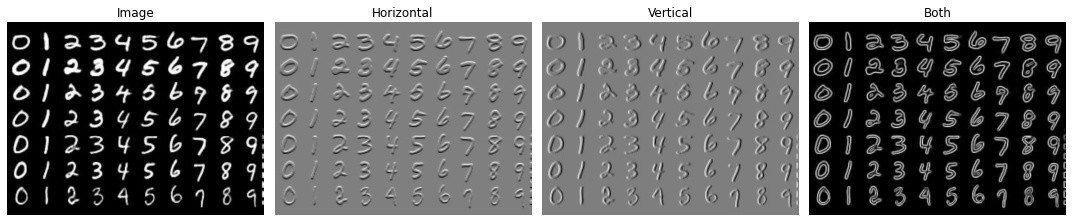

In [32]:

image = ski.io.imread("mnist.jpeg").mean(axis=-1)

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, sharey=True, figsize=(15, 5))
imgs = [image, filters.sobel_h(image), filters.sobel_v(image), filters.sobel(image)]
titles = ["Image", "Horizontal", "Vertical", "Both"]

for ax, img, title in zip(axes.flat, imgs, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Convolutional Neural Networks

Choosing what filters to use and how to use them is really hard. Instead let's learn both the right filters and how to use them.

![image-convolution](classification-cnn@2x-1.jpg)

## Morpheus

[Morpheus](https://morpheus-project.github.io/morpheus/) (arXiv:1906.11248, ApJS, 248, 20) is a deep learning model and software package for the pixel-level morphological classifications of large scale astronomical images.

Using a U-Net like type Convolutional Neural Network, it detects and morphologically classifies sources:

<centering>
<img src="https://raw.githubusercontent.com/ryanhausen/roman-expo-morpheus/main/unet.png" width="512px" height="512px"></img>
</centering>


## Morpheus

![morph](https://morpheus-project.github.io/morpheus/images/zoom_3dhst.png)

## GOODS-South Survey

In [16]:
from IPython.display import display, HTML, IFrame, YouTubeVideo
display(IFrame(src="http://slate.ucsc.edu/~brant/morpheus/mapv12/index_light.html", width=1000, height=600))

# Classifying Variable Sized Images
The image can be any size as long as it's larger than $40\times40$. Morpheus can take care of the rest which includes:
- Windowing input image
- Aggregating outputs into a single output image
- Parallel classification over CPUs or NVIDIA GPUs

## Classifying Variable Sized Images

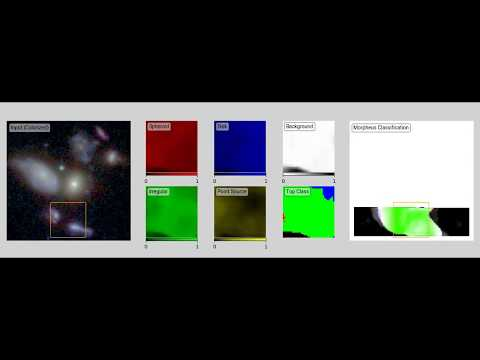

In [4]:
display(YouTubeVideo("hEL1h_dODkU", width=1800, height=600))

## Using Morpheus on the Example Image

Let's analyze an image using Morpheus. Morpheus was trained on F125W, F160W, F606W, and F850LP band images. 

In [5]:
# reminder: from morpheus.data import example
h, j, v, z = example.get_sample()

## Using Morpheus on the Example Image

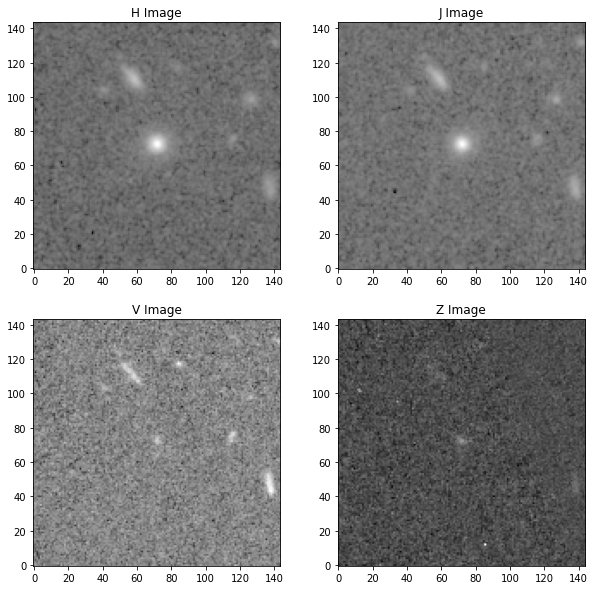

In [6]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band, s in zip(axes, [h,j,v,z], 'HJVZ', [*["log"]*2, *["asinh"]*2]):
    ax.set_title(f'{band} Image')
    if band:arr = np.clip(arr, *AsymmetricPercentileInterval(0.01, 99.999).get_limits(arr))
    ax.imshow(arr, origin='lower', cmap='gray', norm=simple_norm(arr, stretch=s))
plt.show()

## Classifying Images <a name="classification"></a>

To classify an image, use [Classifer.classify](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.classify).
The arguments can be either a file path or a numpy array. The output is a dictionary that contains the
classifications as numpy arrays.

The output is a dictionary that contains a mapping for each pixel which represents the 
probability that a pixel belongs to one of the following classes:

- Spheroid
- Disk
- Irregular
- Point Source (Compact)
- Background

It also contains an output, `n`, indicating the number of times a pixel was classified

## Classifying Images

Morpheus automatically extracts subsets of the image and classifies them in batches. In this example, Morpheus classifies approximately 10,000 subsets of the image and combines them back into the output.

In [17]:
# Reminder: from morpheus.classifier import Classifier
classified = Classifier.classify(h=h, j=j, v=v, z=z, batch_size=2500)

classifying: 5batch [00:28,  5.67s/batch]                                                                                                      


## Classifying Images

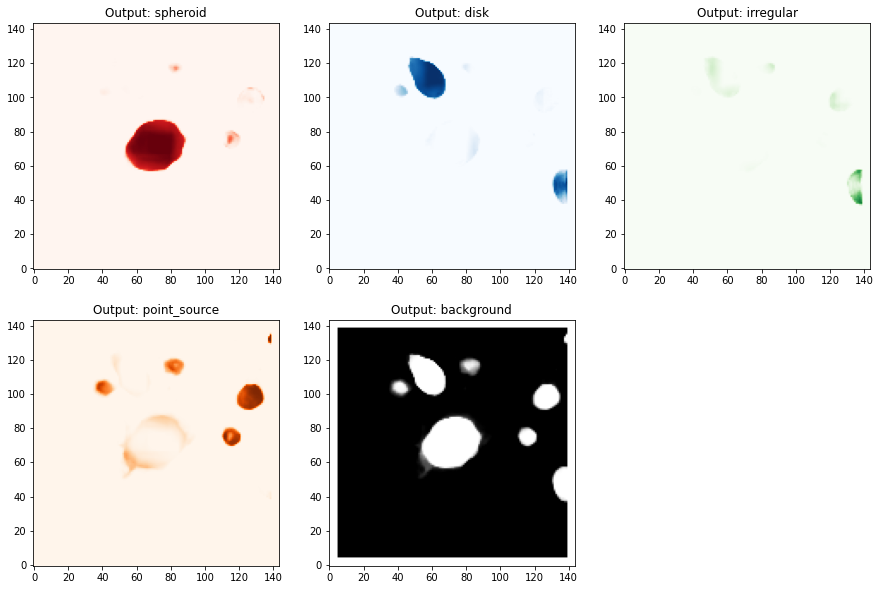

In [8]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = np.array(axes).flatten()
cmaps = ["Reds", "Blues", "Greens", "Oranges", "binary"]

for i, k in enumerate(classified):
    if k=="n":axes[i].axis("off")
    else:
        axes[i].set_title(f'Output: {k}')
        axes[i].imshow(classified[k], origin='lower', vmin=0, vmax=1,cmap=cmaps[i])
plt.show()

### Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [18]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(h, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, h, mask=mask)
print("Done!")

Building Markers...
Watershedding...


/data/groups/comp-astro/ryanhausen/env3.8/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Deblending: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 279.65it/s]


Done!


### Segmentation Map

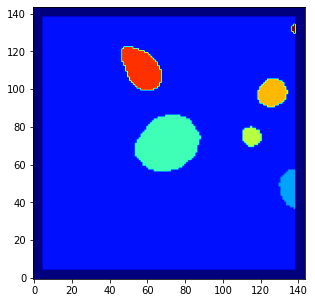

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='jet')
plt.show()

### Cataloging <a name="cataloging"></a>

Morpheus provides a cataloging functionality via [Classifier.catalog_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.catalog_from_classified)
for images that will return all of the detected sources and their morphological classifications.


In [20]:
catalog = Classifier.catalog_from_classified(classified, h, segmap)

### Cataloging

In [21]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[44, 138]	[0.   0.69 0.31 0.  ]
2		[72, 72]	[0.98 0.   0.   0.01]
3		[76, 116]	[0.26 0.   0.   0.73]
4		[98, 126]	[0.04 0.02 0.07 0.87]
5		[110, 58]	[0.   0.95 0.05 0.  ]
6		[131, 138]	[0. 0. 0. 1.]


### Colorizing a Morphological Classification <a name="colorizing_a_morphological_classification"></a>

Use [Classifier.colorize_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified)  to make an RGB. The colors in the output have the following meanings:

- Red = Spheroid
- Blue = Disk
- Green = Irregular
- Yellow = Point Source (compact)
- Back = Background

Note when Morpheus doesn't output a strong classification for any one class they are colored white.

For more information on the coloring scheme see the [documentation](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified).

### Colorizing a Morphological Classification

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 6924.39it/s]


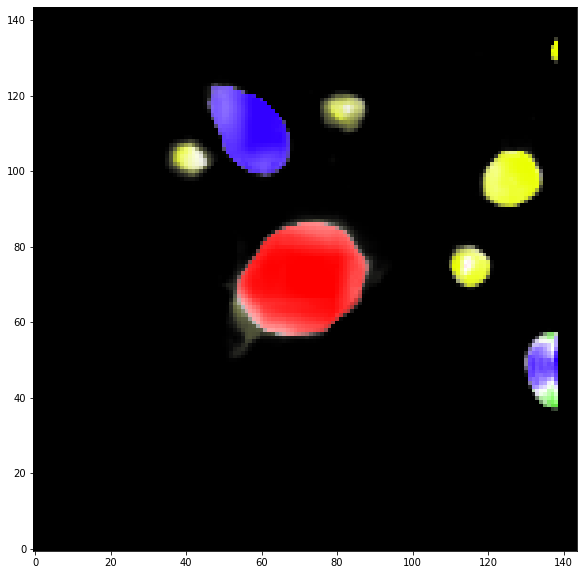

In [22]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.show()

### BigMorpheus

 


BigMorpheus (Hausen & Robertson in prep) leverages the images/classifications from Morpheus to train a much larger classifier that uses a single band.
<img src="https://raw.githubusercontent.com/ryanhausen/roman-expo-morpheus/main/Morpheus-Comparison.png" width="512px" height="512px"></img>


## Scaling Up Your Model: Morpheus-Core

Morphologies are neat, but can we also do **_____**?

Probably! We have released the core "windowing" algorithm from 
Morpheus as **Morpheus-Core** (https://github.com/morpheus-project/morpheus-core) which is also pip installable.

`pip install morpheus-core`

Morpheus-Core will take care of the following:

- Windowing a larger image into batches at the size (height, width) and stride you set
- Aggregating output classifications into an output image of the same size as the input image
- Parallelizing the classification/regression of a large image over CPUs or NVIDIA GPUs

#  Summary

- Morpheus is machine learning model that performs detects and performs pixel-level morphological 
classifications that can scale up survey sized images
- BigMorpheus demonstrates how the initial Morpheus data product can be leveraged to create larger faster 
models for specialized datasets
- Morpheus-Core can scale up any kind of pixel-level model to survey sized images, handling memory and CPU/GPU 
parallelization for the user 
- More information about Morpheus at https://morpheus-project.github.io/morpheus/